Instructions: click restart and run all above. Figures will show once the entire notebook has finished running (this will take a few minutes)

In [1]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from tqdm import tqdm
%matplotlib notebook

# Fitting a simple model of cytoplasmic and membrane protein

I have previously discussed a simplified model of membrane and cytoplasmic protein, presented in Gross et al., 2018, which attempts to describe cross-cortex profiles as a function of local cytoplasmic and membrane concentrations, accounting for light scattering within the plane of the image. 

Here, I discuss an efficient computational method used to fit this model to whole images of a straightened cortex, in order to extract cytoplasmic and membrane concentration distributions. Whilst there are limitations to this model, as discussed previously, it will be sufficient in cases where accuracy isn't essential, and serves as a useful starting point to present the optimisation methods used in this project.

### Method overview

Across a straightened image we will have n_x cross-cortex profiles, each of which is a function of local cytoplasmic and a membrane concentration. By fitting the model to these profiles, we can extract a cytoplasmic and membrane concentration at each position. The model has an additional parameter, sigma, describing the degree of in-plane light scattering, which will be the same throughout the image (and any image with the same imaging conditions). This is unknown, and can also be fit to the data. Finally, an additional parameter is needed to properly align the model to each profile in the y direction.

For the whole straightened image, we therefore have 3 * n_x + 1 total parameters to consider:
- n_x local cytoplasmic concentration parameters
- n_x local membrane concentration parameters
- n_x local alignment parameters
- a single sigma parameter

To find these parameters, we will build a 2D model of a straightened cortex, and optimise all parameters simultaneously using a gradient descent algorithm. This can be significantly more computationally efficient than fitting each position separately, and allows us to find the optimal value of the global parameter sigma that maximises the closeness of fit across the whole image.

### Import and straighten image

See [here](./appendix_rois_and_straightening.ipynb) for demonstration of the straightening algorithm. We will import a rough ROI that's been defined previously.

In [2]:
from membranequant.funcs import load_image, straighten

path = '../test_datasets/dataset2_par2_neon/01/'
img = load_image(path + '/af_corrected.tif')
roi = np.loadtxt(path + '/ROI.txt')
straight = straighten(img, roi=roi, thickness=50)

### Preprocess image

The function below applies a rolling average filter to reduce noise, and normalises the image to between 0-1. This is the target image that we will fit to a model.

Later, we will re-normalise everything back using the saved norm parameter

<IPython.core.display.Javascript object>


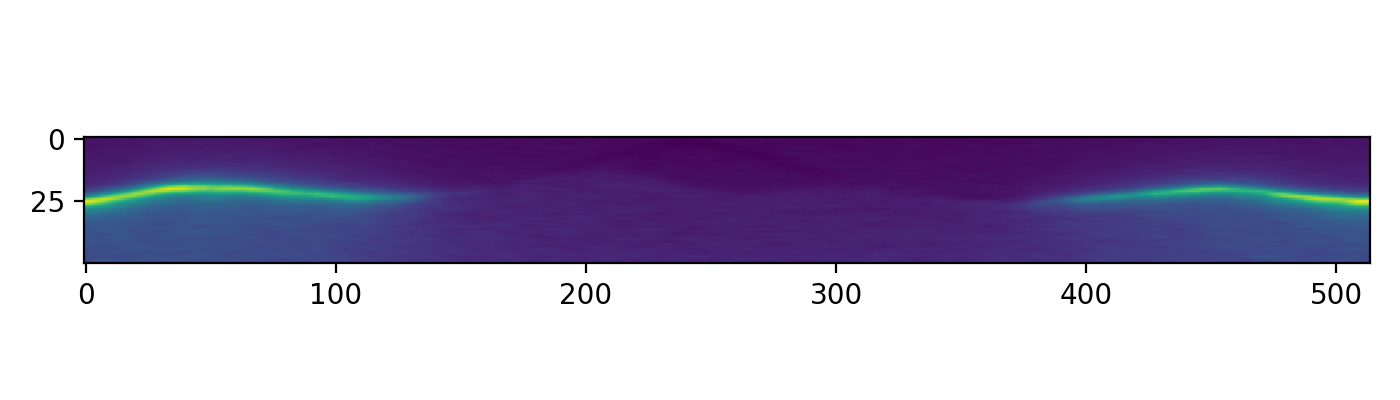

In [3]:
from membranequant.funcs import load_image, straighten, rolling_ave_2d

def preprocess(straight, rol_ave_window=10):
    # Smoothen
    straight_filtered = rolling_ave_2d(straight, window=rol_ave_window, periodic=True)
    
    # Normalise
    norm = np.percentile(straight_filtered, 99)
    target = straight_filtered / norm
    
    return target, norm

target, norm = preprocess(straight)

fig, ax = plt.subplots()
ax.imshow(target)
fig.set_size_inches(7,2)
fig.tight_layout()

### Set up a differentiable model

The full model is described below in the sim_img function, which takes all of the model parameters that we are aiming to optimise (cyts, mems, offsets, sigma), and performs a series of vectorised computations to return a single simulated image. The aim of the optimisation will be for this simulated image to resemble the true image as much as possible, and we want to find the input parameters that best achieve this.

The freedom parameter for sim_img specifies the degree of freedom that is allowed in the offset parameters (e.g. when freedom = 20 this restricts offsets to +-20 pixels).

We must also specify a loss function, which returns a single number representing the difference between the model output and the target image. This is the measure that the optimisation algorithm will aim to minimise. We will use mean squared error for this.

The functions below are written using the machine learning package tensorflow, which uses a differentiable programming paradigm to perform computationally efficient gradient descent. By calculating the gradient of all of the individual operations in the computational pathway from input parameters > simulated image > loss, the system is able to backwards propagate using the chain rule, and calculate the partial derivatives of the loss function with respect to each of the input parameters. This tells the system which direction the parameters need to be moved in to reduce the loss value, which is the basis of gradient descent.

In [4]:
import tensorflow as tf

def sim_img(cyts, mems, offsets, sigma, thickness=50, freedom=10):
    nfits = cyts.shape[0]
        
    # Constrain offsets
    offsets_ = freedom * tf.math.tanh(offsets)

    # Positions to evaluate mem and cyt curves
    positions = tf.reshape(tf.reshape(tf.tile(tf.range(thickness, dtype=np.float64), [nfits]),
                                      [nfits, thickness]) + tf.expand_dims(offsets_, -1), [-1])

    # Mem component
    mem_curve = tf.math.exp(-((positions - thickness / 2) ** 2) / (2 * sigma ** 2))
    
    # Cyt component
    cyt_curve = (1 + tf.math.erf((positions - thickness / 2) / sigma)) / 2
    
    # Reshape
    cyt_curve_ = tf.reshape(cyt_curve, [nfits, thickness])
    mem_curve_ = tf.reshape(mem_curve, [nfits, thickness])

    # Calculate output - a simulated image
    mem_total = mem_curve_ * tf.expand_dims(mems, axis=-1)
    cyt_total = cyt_curve_ * tf.expand_dims(cyts, axis=-1)
    return tf.transpose(tf.math.add(mem_total, cyt_total))

def loss_function(target_image, sim):
    return tf.math.reduce_mean((sim - target_image) ** 2)

### Initiate parameters

This function creates tensorflow variables for all of the parameters that we will optimise (i.e. inputs to the above model), specifying the starting conditions for gradient descent. We will start all concentrations and alignment parameters at 0, and sigma at 1.

In [5]:
def init_params(target):
    nfits = target.shape[1]
    offsets = tf.Variable(np.zeros(nfits))
    cyts = tf.Variable(np.zeros(nfits))
    mems = tf.Variable(np.zeros(nfits))
    sigma = tf.Variable(1.0, dtype=tf.float64)
    return cyts, mems, offsets, sigma

### Perform gradient descent

We will perform gradient descent to optimise parameters in an iterative process. At each iteration, the algorithm will perform a forward pass, simulating an image with current parameters and calculating the associated loss. This is followed by a backwards pass, in which it calculates the gradient of the loss function with respect to each of the input parameters (those specified in var_list). The algorithm will then change all of the input parameters by a small amount according to these gradients (which is controlled by an optimiser), aiming to move down the energy landscape. By iterating this process, we will eventually reach a minimum in the energy landscape, and the parameters that we are optimising will settle. 

We will use the Adam optimiser in tensorflow to control gradient descent. This has proven to be a robust and effective algorithm for training deep neural networks, which it was originally designed for, but has a number of features that make it effective for our problem compared to simpler gradient descent algorithms:
- adaptive learning rate, meaning that it computes individual learning rates for all of the different parameters. This is appropriate here as we have a mix of local parameters (cyts, mems, offsets) and global parameters (sigma), which may have vastly different gradients with respect to the loss function, hence requiring different learning rates.
- momentum speeds up training, and prevents entrapment in local minima.

We must specify an appropriate learning rate (0.01 usually works well), and run the optimisation for enough iterations so that the loss reaches a plateau (200-500 is usually plenty). (By contrast, the simpler SGD optimiser, which lacks the above features, performs poorly at all learning rates.)

We can see that as optimisation runs, the simulated image gradually starts to resemble the true image as input parameters are refined, until a plateua is reached.

100%|██████████| 200/200 [00:02<00:00, 99.87it/s] 


<IPython.core.display.Javascript object>


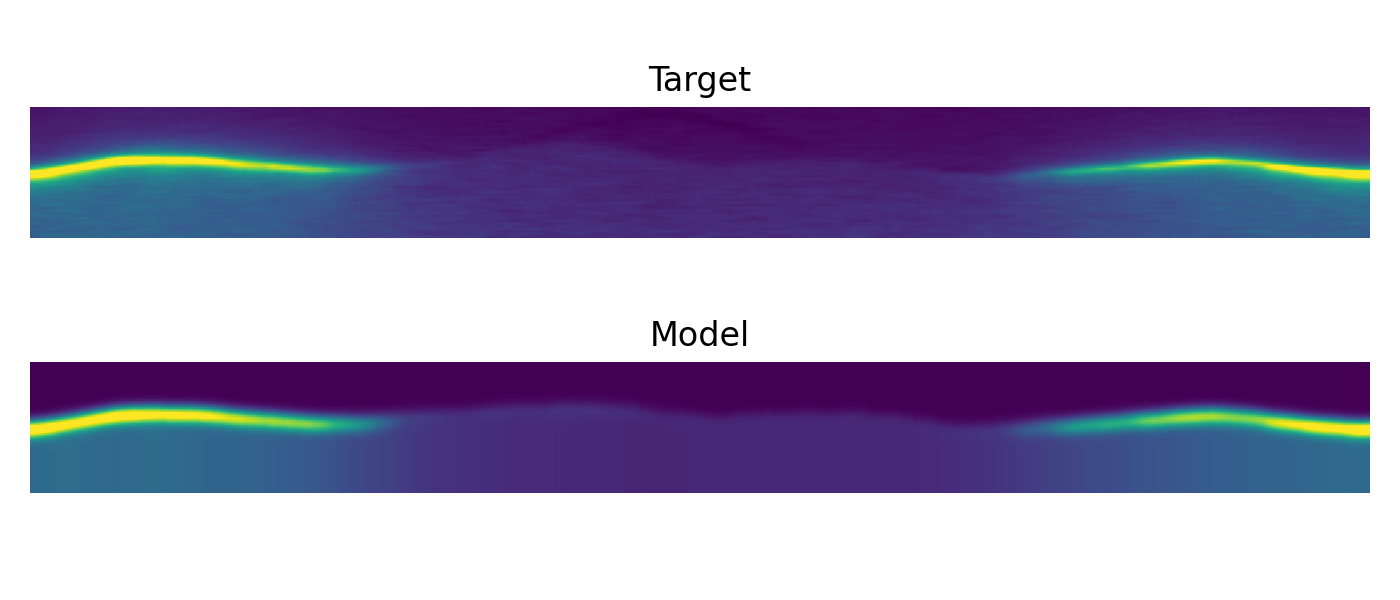

interactive(children=(IntSlider(value=200, description='iteration', max=200, step=10), Output()), _dom_classes…

In [6]:
def optimise(target, lr=0.01, iterations=200):
    save_gap = 10
    saved = []
    
    # Init parameters
    cyts, mems, offsets, sigma = init_params(target)
    
    # Gradient descent
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    losses = np.zeros(iterations)
    for i in tqdm(range(iterations)):   
        with tf.GradientTape() as tape:
            sim = sim_img(cyts, mems, offsets, sigma)
            loss = loss_function(target, sim)
            losses[i] = loss
            var_list = [offsets, cyts, mems, sigma]
            grads = tape.gradient(loss, var_list)
#             print(grads[-1])
            opt.apply_gradients(list(zip(grads, var_list)))
        
        # Save fit
        if i == 0 or (i + 1) % save_gap == 0: 
            saved.append(sim)
    
    # Interactive plot
    fig, (ax1, ax2) = plt.subplots(2, 1)
    @widgets.interact(iteration=(0, iterations, save_gap))
    def update(iteration=2000): 
        ax1.clear()
        ax1.set_title('Target')
        ax1.imshow(target, vmin=0, vmax=1)
        ax1.set_axis_off()
        
        ax2.clear()
        ax2.set_title('Model')
        ax2.imshow(saved[int(iteration / save_gap)], vmin=0, vmax=1)
        ax2.set_axis_off()
            
    fig.set_size_inches(7, 3)
    fig.tight_layout()
    return cyts, mems, offsets, losses, sigma
            
cyts, mems, offsets, losses, sigma = optimise(target)

Check that training has reached a plateau:

<IPython.core.display.Javascript object>


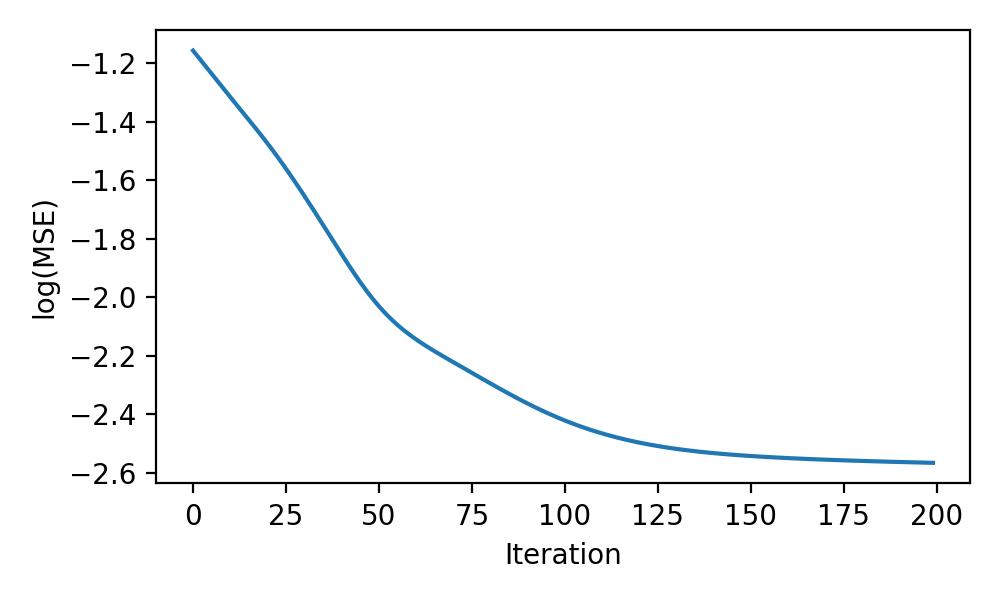

In [14]:
fig, ax = plt.subplots()
ax.plot(np.log10(losses))
ax.set_xlabel('Iteration')
ax.set_ylabel('log(MSE)')
fig.set_size_inches(5,3)
fig.tight_layout()

### Evaluating the final model

We can further evaluate the quality of the final model by comparing the shape of local profiles with the target image. In this case we can see that the fits look appropriate across the whole image. However, we somewhat fail to closely to capture the true shape of the target profiles

<IPython.core.display.Javascript object>


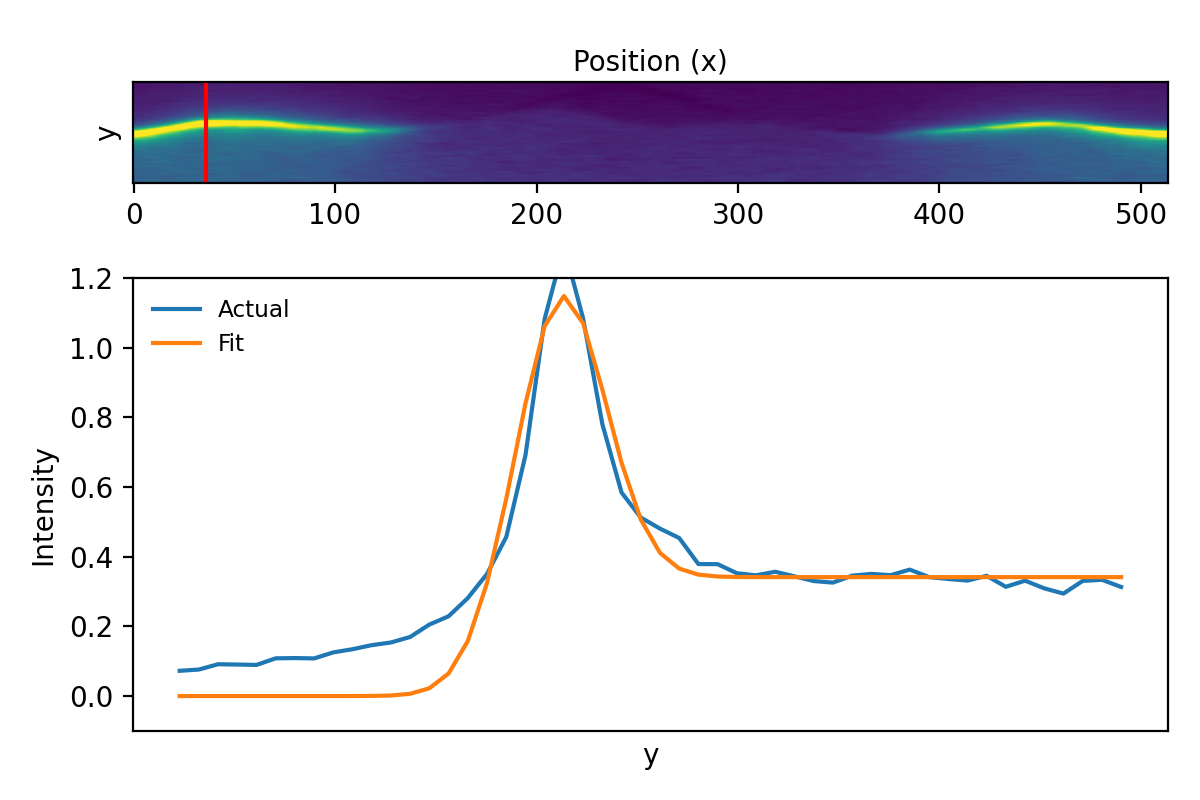

interactive(children=(IntSlider(value=10, description='position', max=514), Output()), _dom_classes=('widget-i…

In [8]:
def evaluate_model_fig():
    fig = plt.figure()
    gs = fig.add_gridspec(3, 3)
    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1:, :])
    sim = sim_img(cyts, mems, offsets, sigma)

    @widgets.interact(position=(0, target.shape[1], 1))
    def update(position=10):

        ax1.clear()
        ax1.imshow(target, vmin=0, vmax=1)
        ax1.axvline(position, c='r')
        ax1.set_yticks([])
        ax1.set_xlabel('Position (x)')
        ax1.xaxis.set_label_position('top')
        ax1.set_ylabel('y')

        ax2.clear()
        ax2.plot(target[:, position], label='Actual')
        ax2.plot(sim[:, position], label='Fit')
        ax2.set_xticks([])
        ax2.set_ylabel('Intensity')
        ax2.set_xlabel('y')
        ax2.legend(frameon=False, loc='upper left', fontsize='small')
        ax2.set_ylim(bottom=-0.1, top=1.2)

    fig.set_size_inches(6, 4)
    fig.tight_layout()
    
evaluate_model_fig()

### Print optimised sigma value

In [9]:
print('Sigma = %.2f' % sigma)

Sigma = 2.39


### Plot membrane and cytoplamic protein distributions

Rescale concentrations by the normalisation factor (norm) that we used earlier, and plot results

<IPython.core.display.Javascript object>


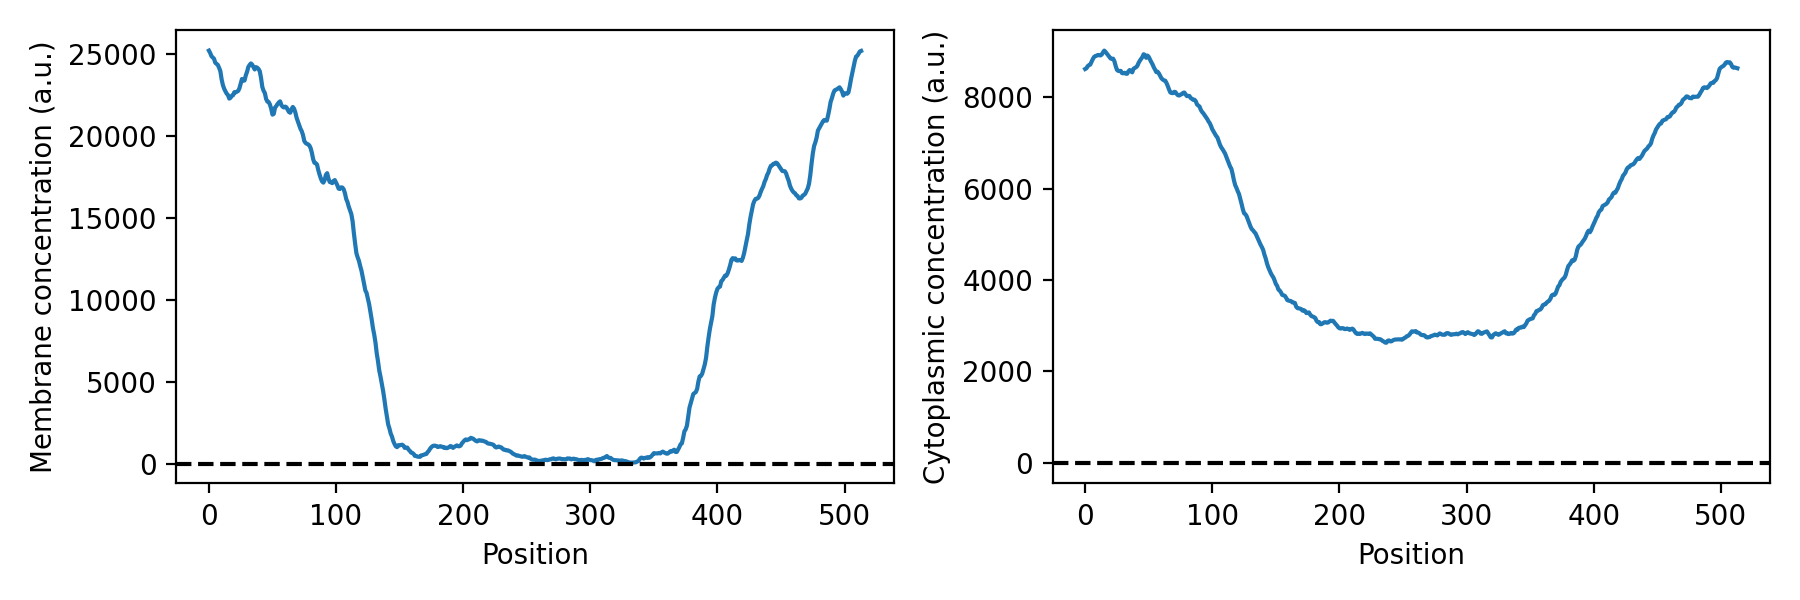

In [10]:
fig, (ax1, ax2) = plt.subplots(1,2)

ax1.plot(mems.numpy() * norm)
ax1.axhline(0, c='k', linestyle='--')
ax1.set_xlabel('Position')
ax1.set_ylabel('Membrane concentration (a.u.)')

ax2.plot(cyts.numpy() * norm)
ax2.axhline(0, c='k', linestyle='--')
ax2.set_xlabel('Position')
ax2.set_ylabel('Cytoplasmic concentration (a.u.)')

fig.set_size_inches(9, 3)
fig.tight_layout()

Interestingly we can see a strong gradient in the quantified cytoplasmic concentrations that closely follows the membrane gradient. This is unexpected, as cytoplasmic concentrations are generally regarded to be uniform for PAR-2 due to fast diffusion. However, it is likely that a lot of the 'cytoplasmic' signal that we see in the posterior is actually out of focus signal from above and below the focal plane, something our current model does not account for. For PAR-2, this would suggest that just over half of the percieved cytoplasmic signal in the posterior is not real. We can fix this by using a more flexible model that can account for this out of focus contribution. [(Next notebook)](./4_custom_model.ipynb)

### Refining the ROI

As well as local cytoplasmic and membrane concentrations, the model also outputs an offset value at each position, representing (in pixel units), the deviation in the alignment between the model and the local profile. We can apply these offsets to our original ROI, to generate a new ROI that more accurately follows the cortex. 

This is a two step process:
1. move the individual points in the ROI perpendicular to the tangent of the ROI, according to local offset values (using the offset_coordinates function)
2. fit a spline to the new points, and evaluate the spline at pixel-width distances (using the spline_roi function)

This can serve as an easy way to perform accurate segmentation at the sub-pixel level.

<IPython.core.display.Javascript object>


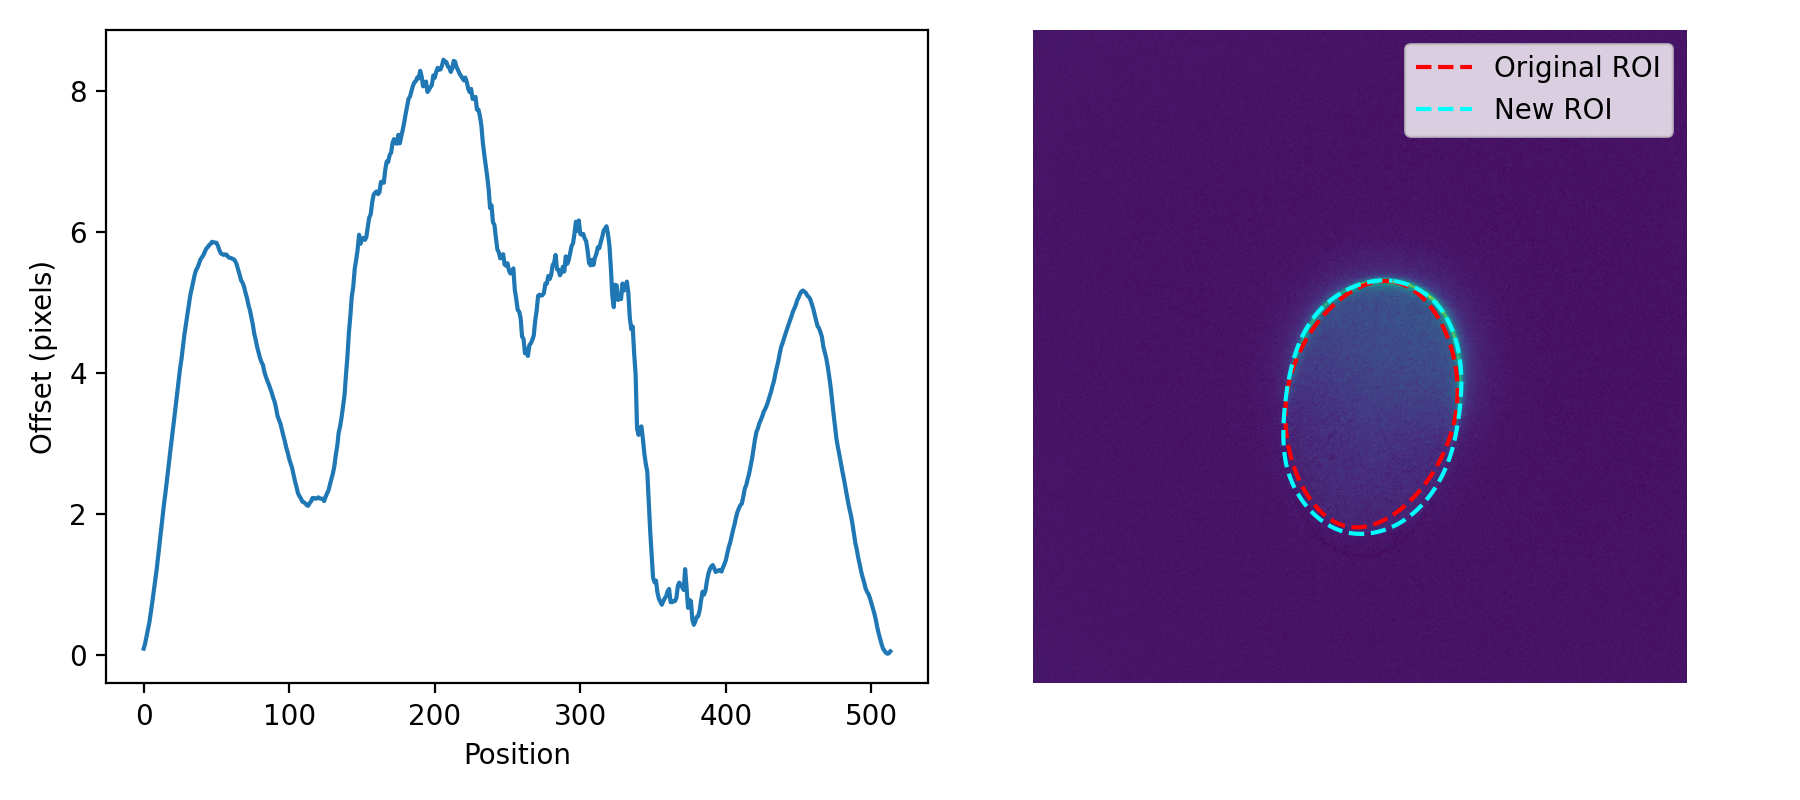

In [11]:
from membranequant.roi import offset_coordinates, spline_roi

# Create new ROI
offsets_ = 10 * tf.math.tanh(offsets)
roi_new = offset_coordinates(roi, offsets_)
roi_new = spline_roi(roi=roi_new, periodic=True, s=100)

def refine_roi_fig():
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.plot(offsets_.numpy())
    ax1.set_xlabel('Position')
    ax1.set_ylabel('Offset (pixels)')
    ax2.imshow(img)
    ax2.plot(roi[:, 0], roi[:, 1], c='r', linestyle='--', label='Original ROI')
    ax2.plot(roi_new[:, 0], roi_new[:, 1], c='aqua', linestyle='--', label='New ROI')
    ax2.legend()
    ax2.set_axis_off()
    fig.set_size_inches(9,4)
    fig.tight_layout()
    
refine_roi_fig()

With this new ROI, we can re-straighten and redo the optimisation:

100%|██████████| 200/200 [00:01<00:00, 105.58it/s]


<IPython.core.display.Javascript object>


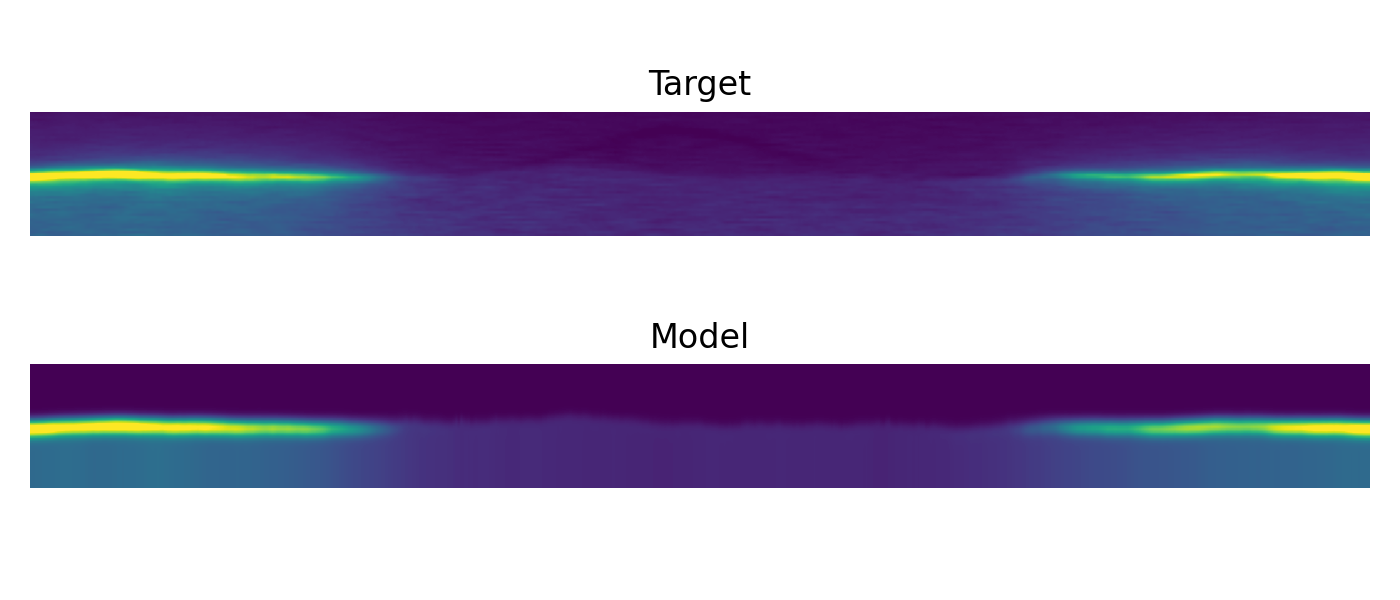

interactive(children=(IntSlider(value=200, description='iteration', max=200, step=10), Output()), _dom_classes…

In [12]:
straight2 = straighten(img, roi=roi_new, thickness=50)
target2, norm2 = preprocess(straight2)
cyts2, mems2, offsets2, losses2, sigma2 = optimise(target2)

# Summary

In this notebook, I have presented a computationally efficient implementation of the quantification model presented in Gross et al., 2018. Using a gradient descent method, we are able to simultaneously fit local cytoplasmic and membrane concentrations, align the model at each position, and optimise the unknown global parameter sigma. The Adam optimiser speeds up optimisation compared to simpler optimisers, prevents entrapment in local optima, and succesfully deals with a mix of local and global parameters that vary wildly in their relationship to the final loss function.

For simplicity, I have performed optimisation here on a single image, with a 2D model representing a single straight image. By extension, if we have multiple images taken with the same imaging conditions, we could train these images together to obtain concentration parameters for each image, and the single value of sigma that minimises loss across all images. This is a method that's built into the ImageQuant class contained in this package, which I present [here](./5_intro_to_imagequant.ipynb).

By aligning the model to the image at each position, we get a set of values which can be used to refine the ROI. Using an iterative approach, we can simultaneously perform quantification and segmentation at the sub-pixel level, starting from an initial input ROI that isn't very accurate. Two iterations, as we have done here, is usually sufficient.

Finally, whilst this model gives us a quantitative measure of cytoplasmic and membrane concentrations, it's important to note that the accuracy of these concentrations is limited by the accuracy of the model itself and its inbuilt assumptions. We can see from the cytoplasmic quantification of this image that the model predicts an unphysiological cytoplasmic gradient, likely stemming from its inability to account for out of focus cortical signal in the posterior. If we assume that cytoplasmic gradients are actually flat across the cell (i.e. close to the concentration that we have measured here in the anterior), then we get a quantitative sense of the amount of out of focus bleedthrough (just over half of the 'cytoplasmic' signal that we see in the posterior). Clearly our ability to quantify cytoplasmic concentrations is impacted, but this will also affect our quantification of membrane concentrations, as we are attributing signal to cytoplasmic protein that we should be attributing to membrane protein. Therefore, in order to accurately quantify concentrations, we must build a model that accounts for this bleedthrough of out of focus light. We will do this [in the next notebook](./4_custom_model.ipynb)